# Proyecto Final - Predicción del Test de Bechdel

El test de Bechdel es un método informal para evaluar la representación de las mujeres en obras de ficción como películas o series. Para aprobar el test, una obra debe cumplir tres criterios: debe haber al menos dos mujeres con nombre propio, deben hablar entre ellas y la conversación no debe ser sobre un hombre. El test no evalúa la calidad o el feminismo de una obra, sino que destaca si los personajes femeninos son tratados como individuos autónomos o solo en relación con personajes masculinos. 

En este notebook, realizamos todo el EDA, hasta la subida de los datasets desde una base PostgreSQL, hasta finalmente realizar el entrenamiento de los datos. Evaluamos distintas métricas como AUC, Accuracy, Precision y Recall, y vemos cuales son las features más importantes. 

# Análisis Exploratorio de datos


En esta sección corremos varias estadísticas para el Entregable #1, aun no subimos los datos de la base creada en PostgreSQL

In [26]:
#Importamos el dataset de bechdel
import requests
import pandas as pd
BASE = "http://bechdeltest.com/api/v1"
def get_all_movies_df():
    #Descargamos todo el listado aprobado
    r = requests.get(f"{BASE}/getAllMovies", timeout=60)
    r.raise_for_status()  # Lanza error si la respuesta no es 200
    data = r.json()
    #Convertimos a DataFrame y seleccionamos columnas útiles
    df = pd.DataFrame(data)[["id", "imdbid", "title", "year", "rating"]]
    #Normalizamos IDs
    df["tconst"] = "tt" + df["imdbid"].astype(str).str.zfill(7)
    # Definimos variable objetivo binaria
    df["pass_bechdel"] = (df["rating"].astype(str) == "3").astype(int)
    #Transformación de datos para mayor facilidad 
    df["year"] = pd.to_numeric(df["year"], errors="coerce")
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    return df
bechdel = get_all_movies_df()
print(bechdel.tail())

          id    imdbid                   title  year  rating      tconst  \
10557  11779  29603959               Novocaine  2025       1  tt29603959   
10558  11785  30840798  Phoenician Scheme, The  2025       3  tt30840798   
10559  11786  32550101                   Straw  2025       3  tt32550101   
10560  11787  30253473            Materialists  2025       3  tt30253473   
10561  11794  14205554      KPop Demon Hunters  2025       3  tt14205554   

       pass_bechdel  
10557             0  
10558             1  
10559             1  
10560             1  
10561             1  


In [ ]:
bechdel.describe()

In [27]:
 import pandas as pd
 from pathlib import Path
 #Validaciones por errores dados por formateo
 if 'tconst' not in bechdel.columns:
    imdbid_num = (
        bechdel['imdbid']
        .astype(str)
        .str.replace('tt', '', regex=False)     
        .str.extract(r'(\d+)', expand=False)   
        .fillna('')                             
    )
    bechdel['tconst'] = 'tt' + imdbid_num.str.zfill(7)
 #Variable objetivo
 if 'pass_bechdel' not in bechdel.columns and 'rating' in bechdel.columns:
    bechdel['pass_bechdel'] = (pd.to_numeric(bechdel['rating'],errors='coerce')==3).astype(int)
 # Aseguramos tipos útiles
 bechdel['tconst'] = bechdel['tconst'].astype('string')
 #Cargamos dataset IMDb
 path_basics  = Path("title.basics.tsv")  
 path_ratings = Path("title.ratings.tsv")
 na_vals = ['\\N', 'NA', 'NaN', ''] 
 basics = pd.read_csv(
    path_basics,
    sep='\t',
    na_values=na_vals,
    usecols=['tconst', 'titleType', 'isAdult', 'runtimeMinutes', 'genres'],
    low_memory=False
 )
 ratings = pd.read_csv(
    path_ratings,
    sep='\t',
     na_values=na_vals,
    usecols=['tconst', 'averageRating', 'numVotes'],
    dtype={'tconst': 'string', 'averageRating': 'float32', 'numVotes': 'Int32'},
    low_memory=False
 )
 # Solo películas y contenido no adulto, para poder homogenizar
 mask_movies = (basics['titleType'].astype(str) == 'movie')
 mask_adult  = (basics['isAdult'].fillna(0) == 0)
 basics = basics[mask_movies & mask_adult].copy()
 #Limpieza rápida de duración
 basics['runtimeMinutes'] = pd.to_numeric(basics['runtimeMinutes'], errors='coerce')
 #Eliminación de outliers
 basics['runtimeMinutes'] = basics['runtimeMinutes'].clip(lower=30, upper=240)
 # Hacemos merge de ambos datasets de IMBd y basics
 imdb_meta = basics.merge(ratings, on='tconst', how='left')
 # Realizamos JOIN de otro tipo para pruebas
 final = bechdel.merge(imdb_meta, on='tconst', how='inner')
 # Generamos varios features con los generos
 if 'genres' in final.columns:
    final['genres'] = final['genres'].fillna('Unknown')
    genre_dummies = final['genres'].str.get_dummies(sep=',')
    final = pd.concat([final, genre_dummies], axis=1)
 #Seleccionamos las columnas finales
 cols_base = [c for c in ['tconst', 'title', 'year', 'rating', 'pass_bechdel'] if c in final.columns]
 cols_imdb = [c for c in ['runtimeMinutes', 'averageRating', 'numVotes', 'genres','titleType','isAdult'] if c in final.columns]
 final = final[cols_base + cols_imdb + [c for c in final.columns if c not in cols_base + cols_imdb]]
 print(final.shape, final.columns.tolist())
 print(final.head(3))
 final.describe()

(9736, 37) ['tconst', 'title', 'year', 'rating', 'pass_bechdel', 'runtimeMinutes', 'averageRating', 'numVotes', 'genres', 'titleType', 'isAdult', 'id', 'imdbid', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'Unknown', 'War', 'Western']
      tconst                         title  year  rating  pass_bechdel  \
0  tt0000009                    Miss Jerry  1894       0             0   
1  tt0000574  Story of the Kelly Gang, The  1906       1             0   
2  tt0002101                     Cleopatra  1912       2             0   

   runtimeMinutes  averageRating  numVotes                      genres  \
0            45.0            5.3       232                     Romance   
1            70.0            6.0      1036  Action,Adventure,Biography   
2           100.0            5.1       659               Drama

,year,rating,pass_bechdel,runtimeMinutes,averageRating,numVotes,isAdult,id,Action,Adventure,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,Unknown,War,Western
count,9736.000000,9736.000000,9736.000000,9728.000000,9723.000000,9723.0,9736.0,9736.000000,9736.000000,9736.000000,...,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000,9736.000000
mean,1998.097062,2.159203,0.573952,105.750925,6.568127,96120.67654,0.0,5565.079088,0.190838,0.175534,...,0.023726,0.093878,0.000411,0.181800,0.071795,0.014893,0.134655,0.000514,0.020234,0.011606
std,22.853202,1.074485,0.494526,20.888404,0.981086,195665.349538,0.0,3331.712337,0.392982,0.380443,...,0.152203,0.291674,0.020266,0.385699,0.258162,0.121132,0.341372,0.022657,0.140808,0.107112
min,1894.000000,0.000000,0.000000,30.000000,1.200000,9.0,0.0,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1989.000000,1.000000,0.000000,92.000000,6.000000,6035.0,0.0,2640.750000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2007.000000,3.000000,1.000000,102.000000,6.700000,26841.0,0.0,5487.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2014.000000,3.000000,1.000000,116.000000,7.300000,100590.5,0.0,8440.250000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2025.000000,3.000000,1.000000,240.000000,9.600000,3117437.0,0.0,11797.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


=== RESUMEN GENERAL ===
Shape: 9736 filas x 38 columnas

Dtypes:
tconst             object
title              object
year                int64
rating              int64
pass_bechdel        int64
runtimeMinutes    float64
averageRating     float32
numVotes            Int32
genres             object
titleType          object
isAdult             int64
id                  int64
imdbid             object
Action              int64
Adventure           int64
Animation           int64
Biography           int64
Comedy              int64
Crime               int64
Documentary         int64
Drama               int64
Family              int64
Fantasy             int64
Film-Noir           int64
History             int64
Horror              int64
Music               int64
Musical             int64
Mystery             int64
News                int64
Romance             int64
Sci-Fi              int64
Sport               int64
Thriller            int64
Unknown             int64
War                 int64

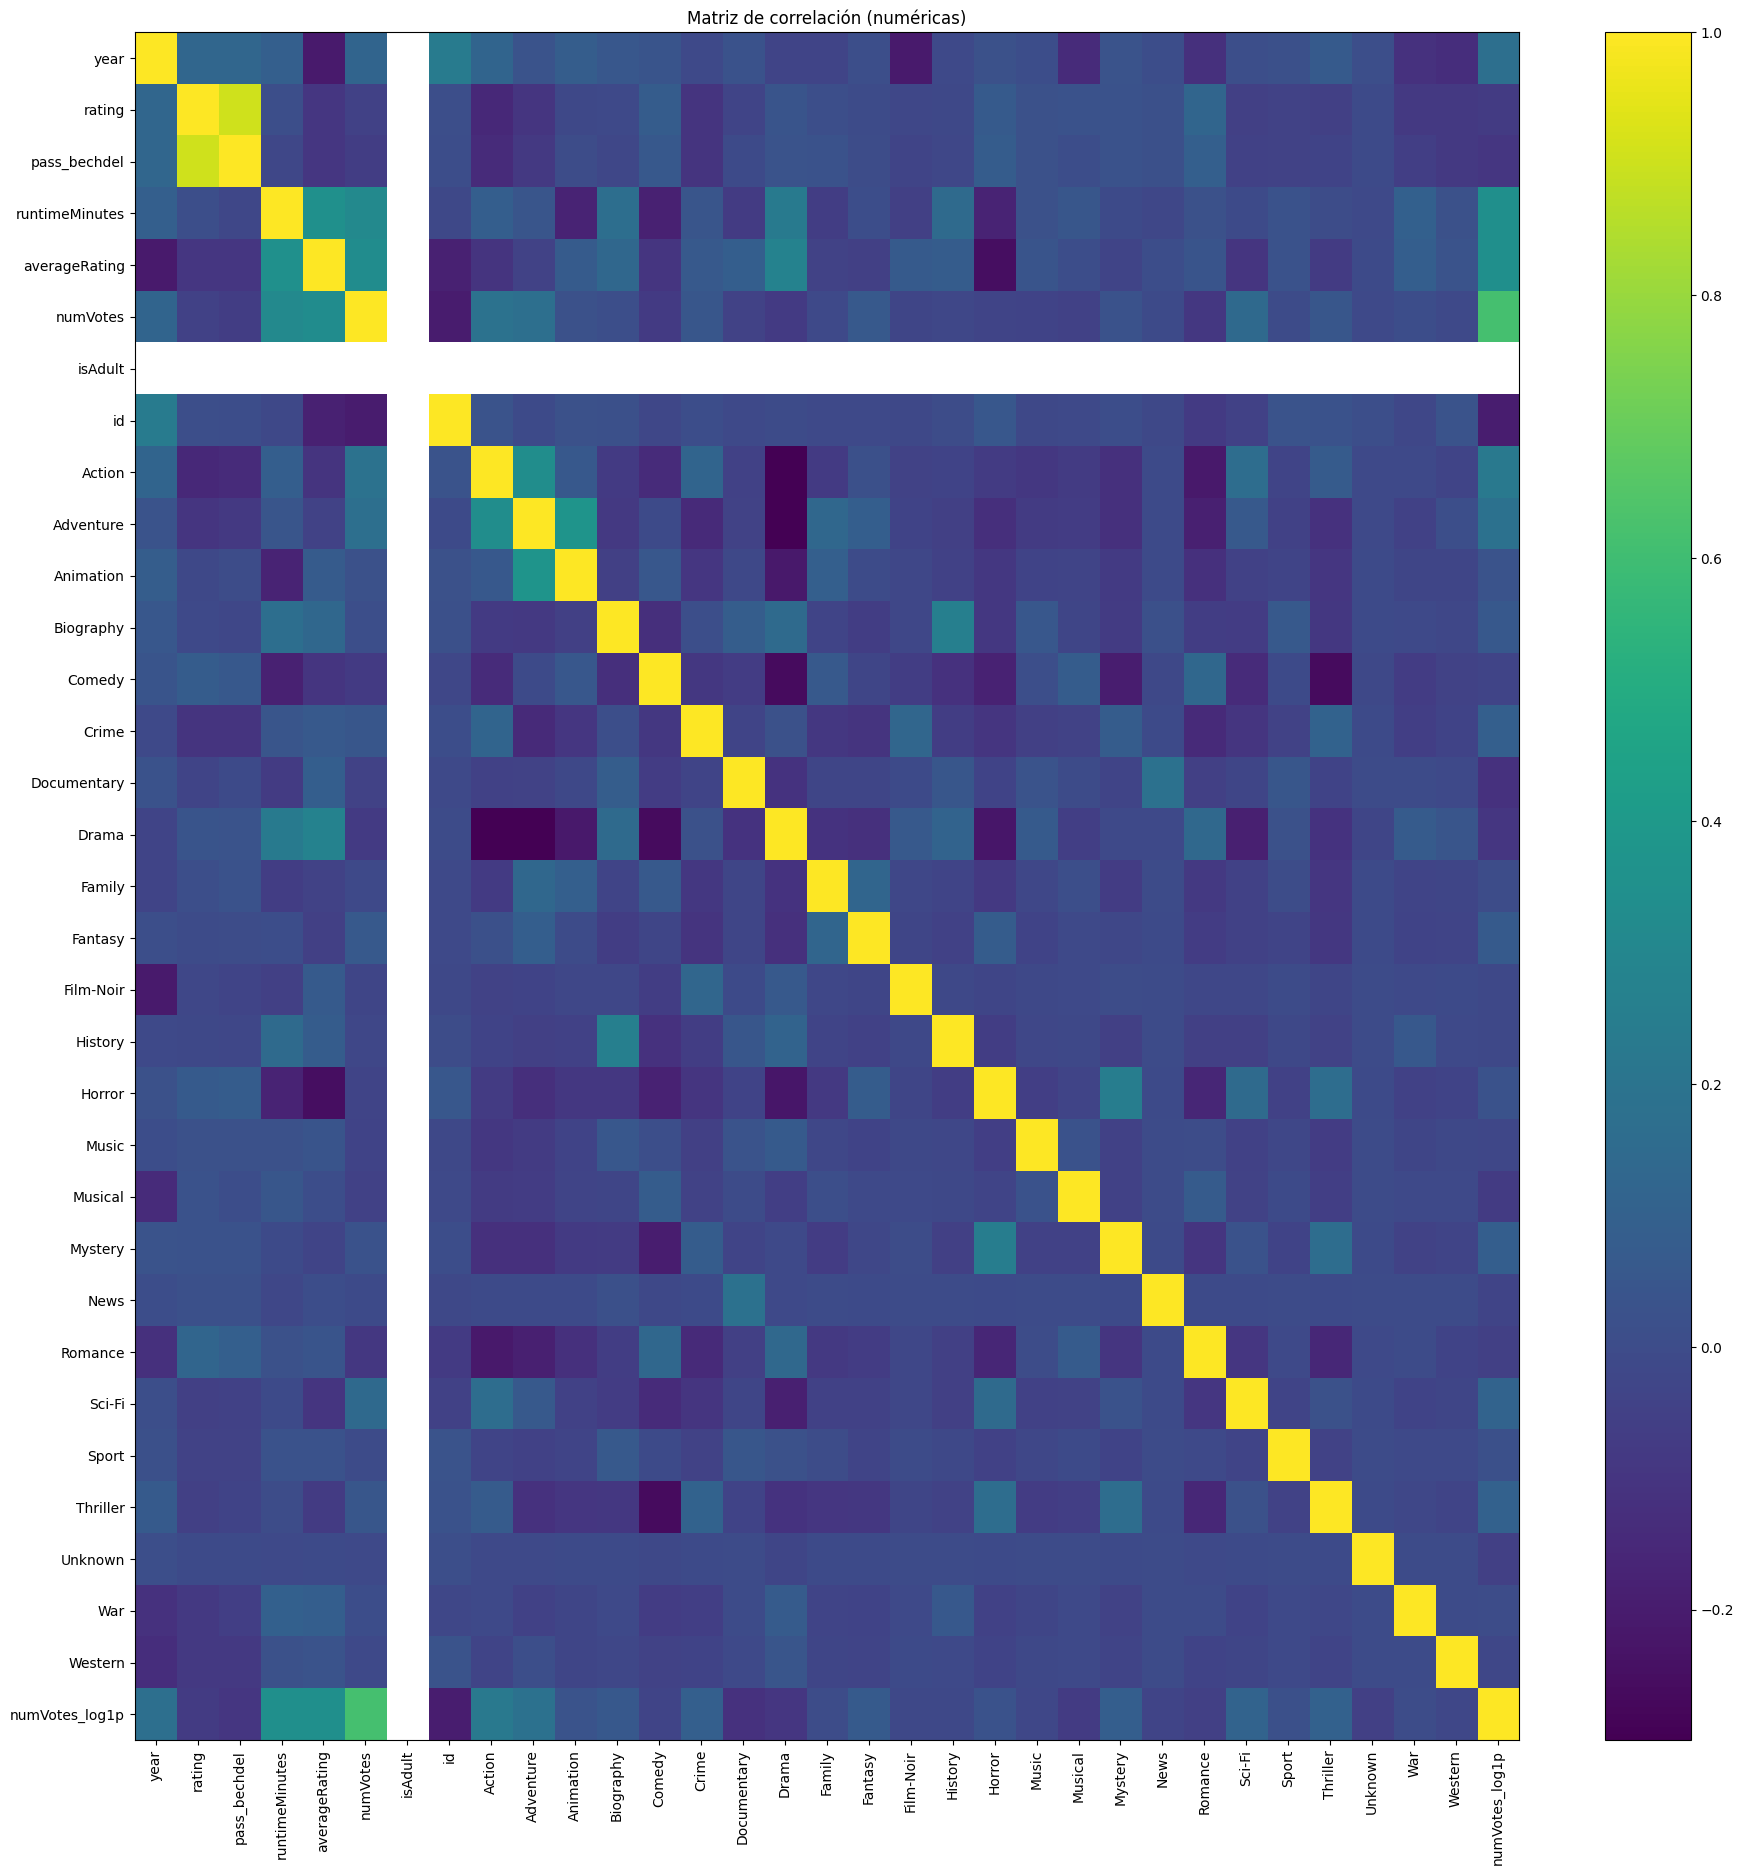


Top correlaciones absolutas con el target:
rating            0.908284
Action            0.139756
year              0.131309
Crime             0.105523
Romance           0.094302
numVotes_log1p    0.093725
averageRating     0.091430
Adventure         0.085112
Western           0.085050
Horror            0.077871
numVotes          0.061577
War               0.060584
Comedy            0.056617
Sci-Fi            0.050040
Sport             0.044968
Thriller          0.038609
Film-Noir         0.033206
Drama             0.032539
Mystery           0.028064
Family            0.027301
Name: pass_bechdel, dtype: float64


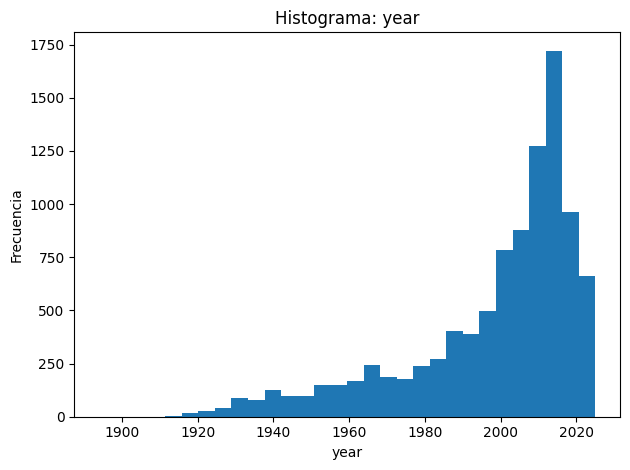

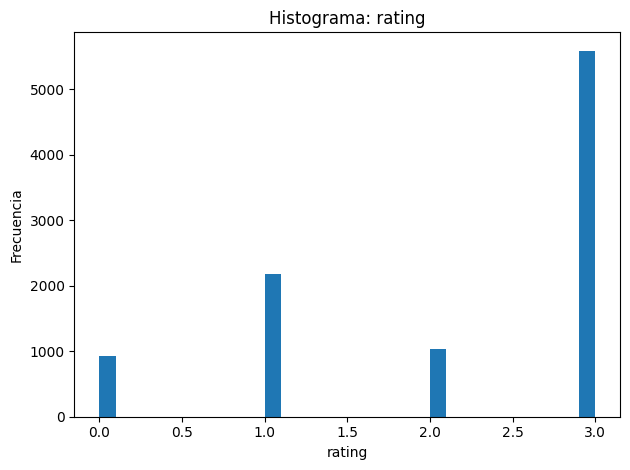

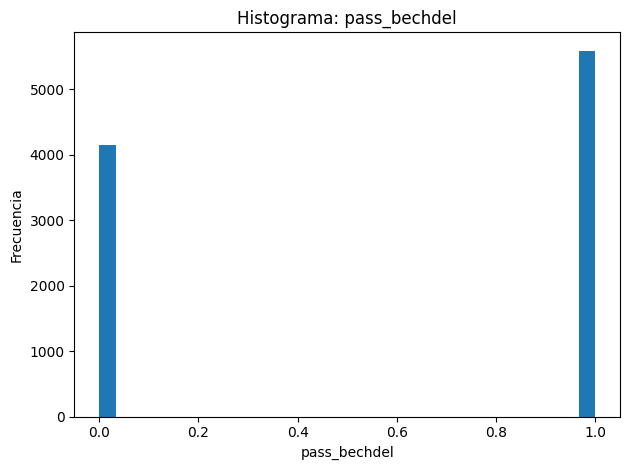

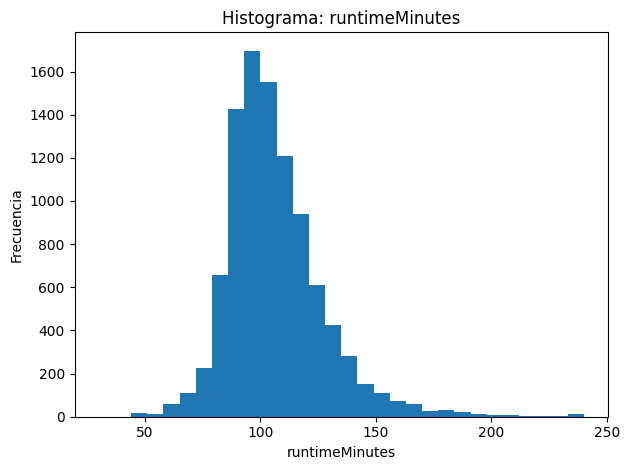

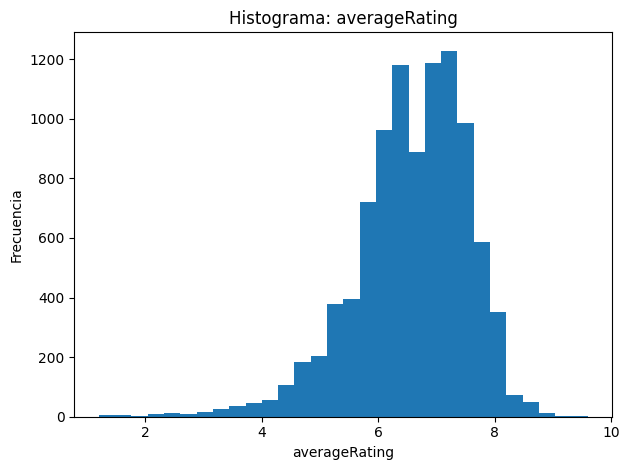

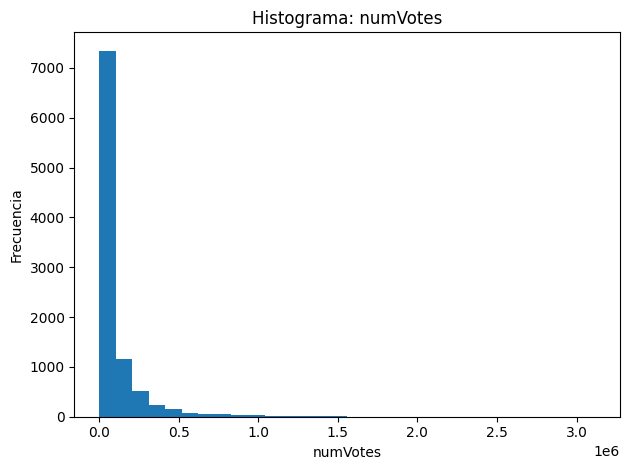

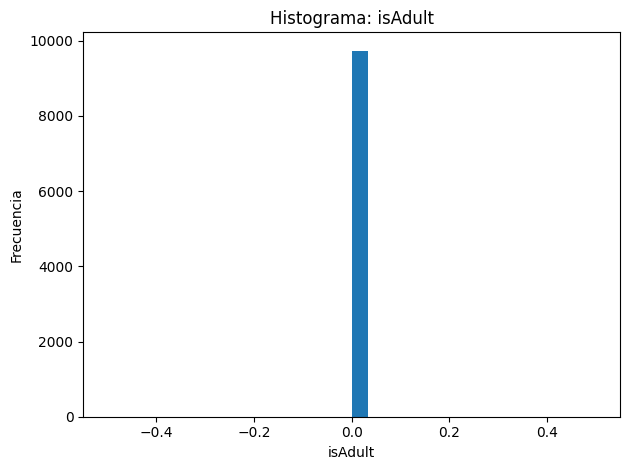

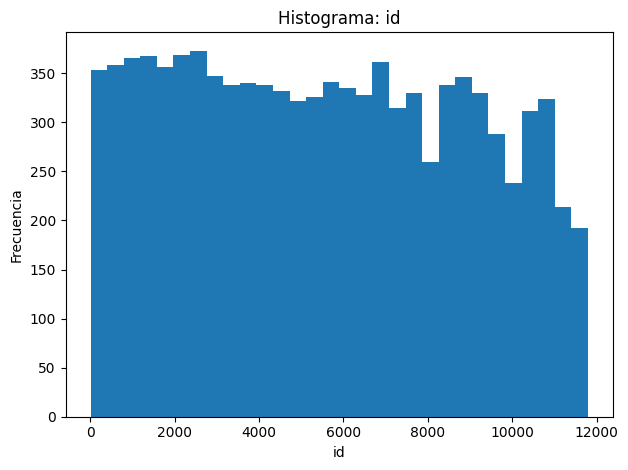

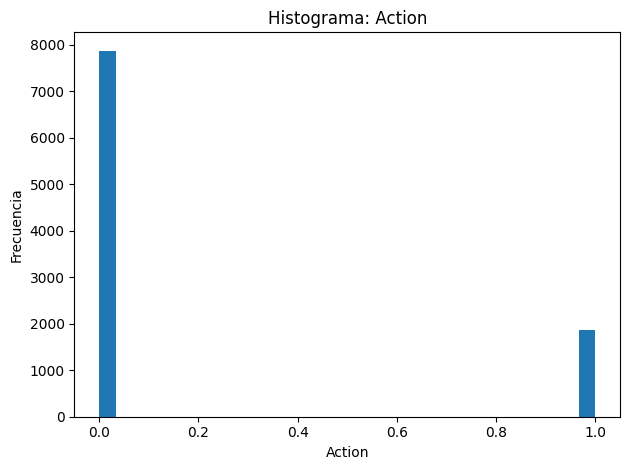

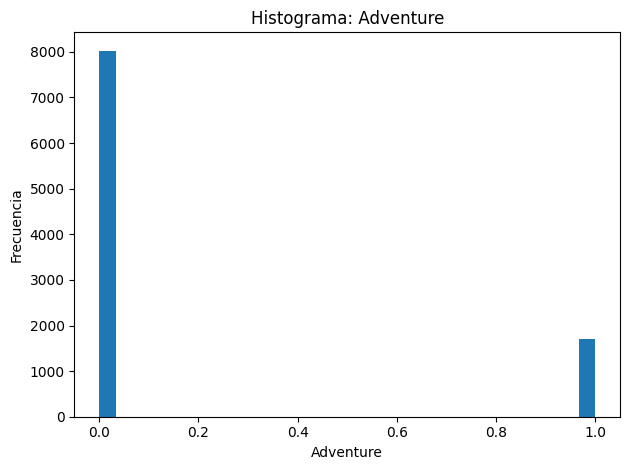

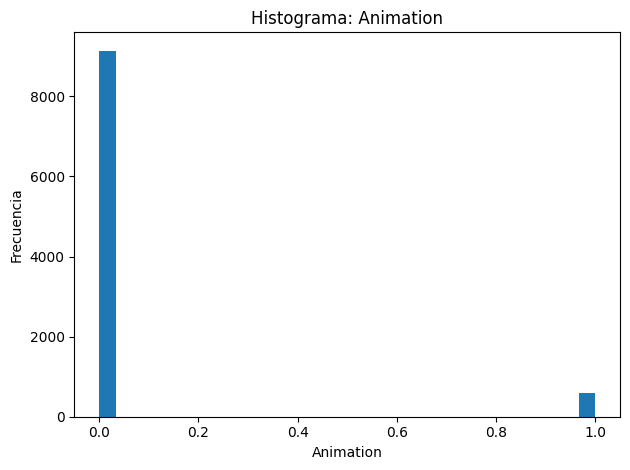

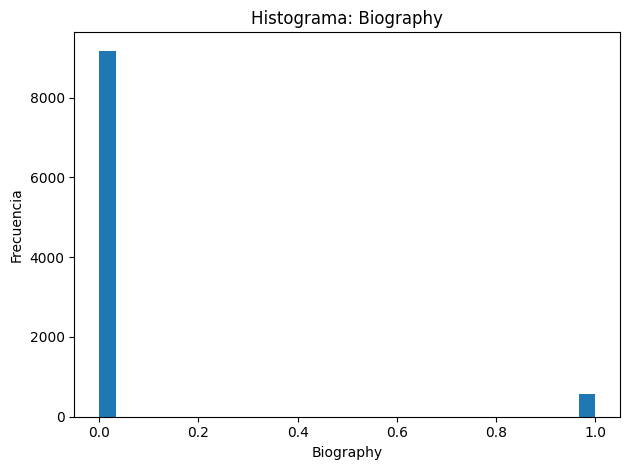

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


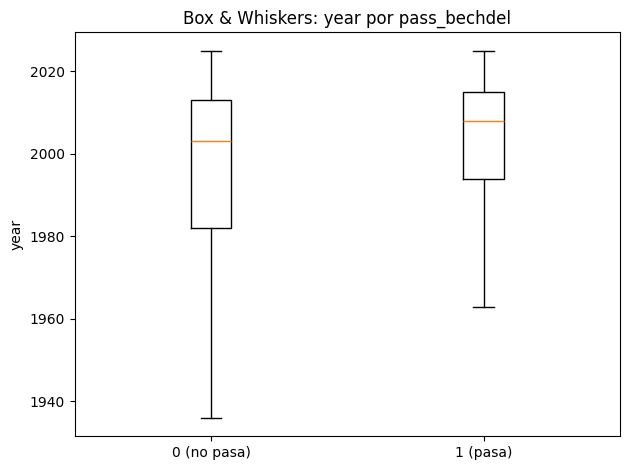

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


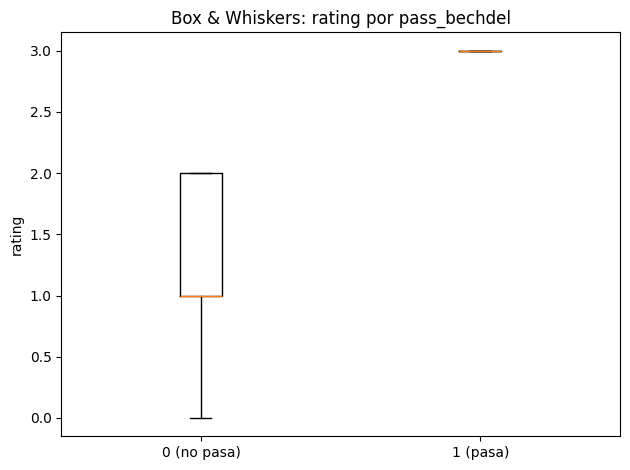

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


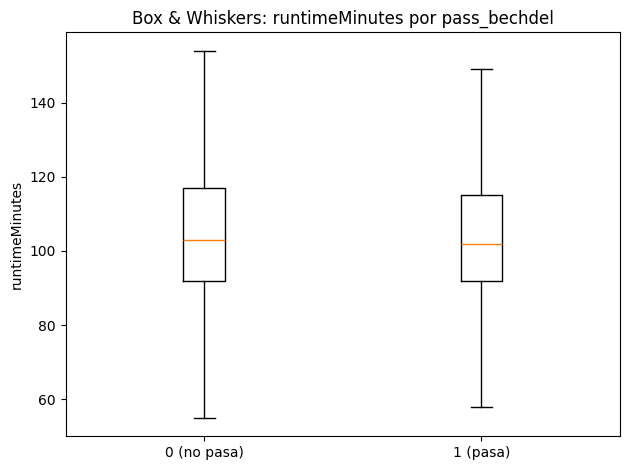

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


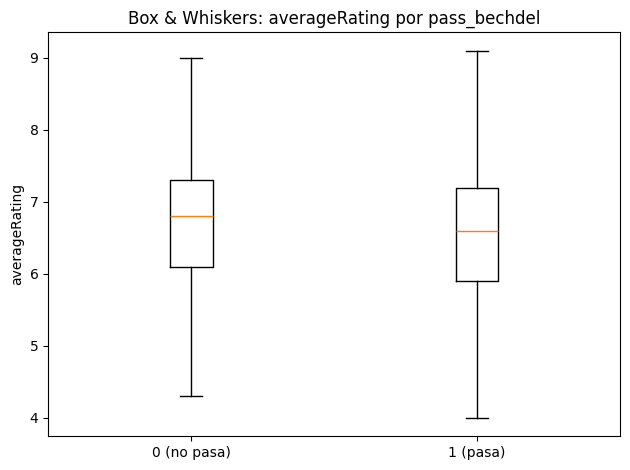

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


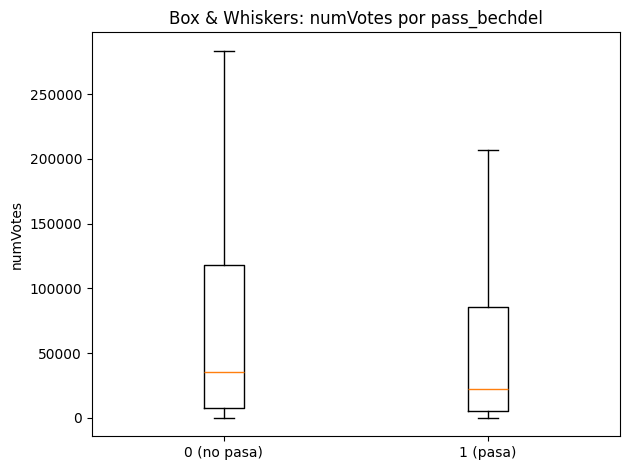

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


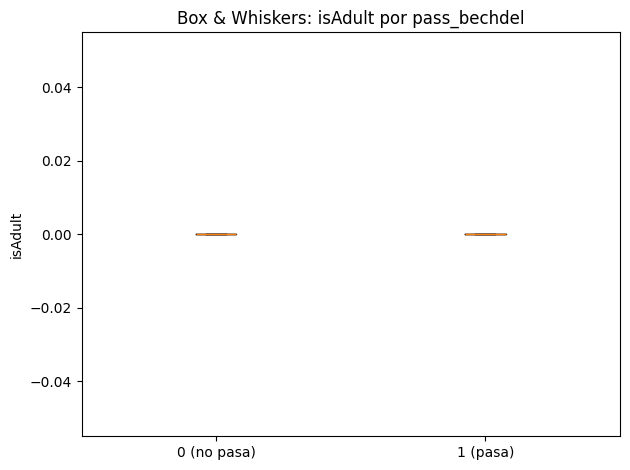

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


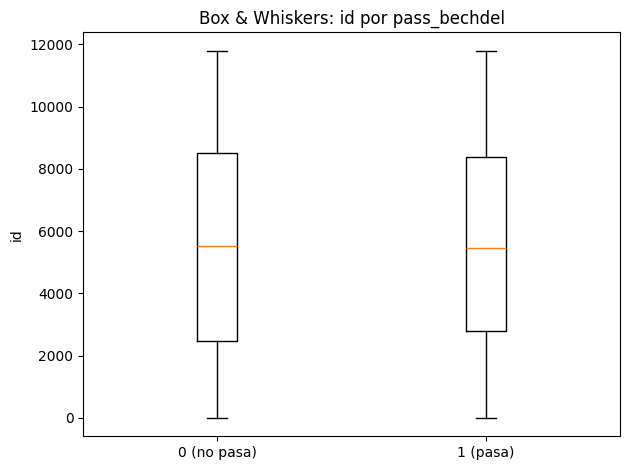

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


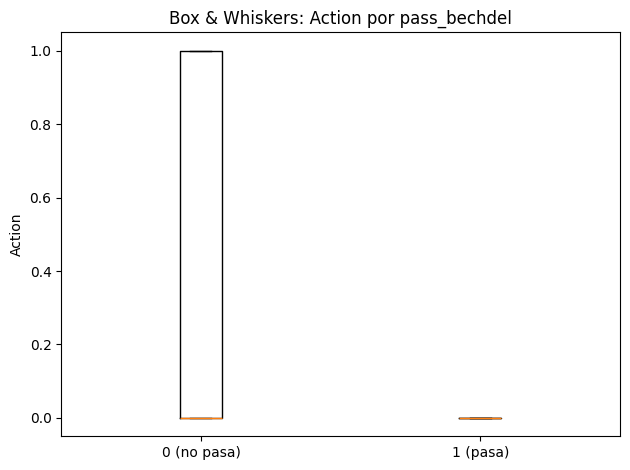

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


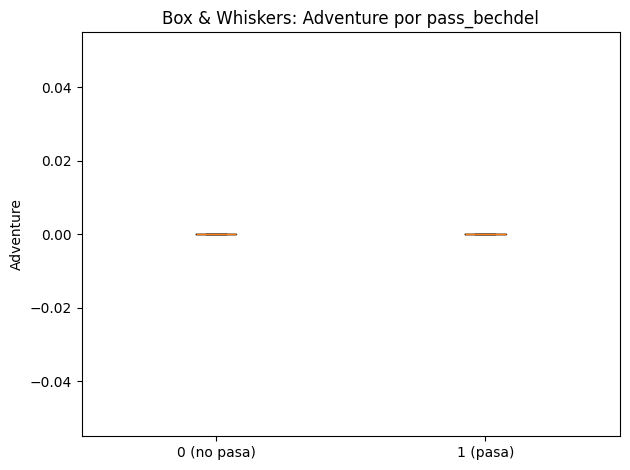

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


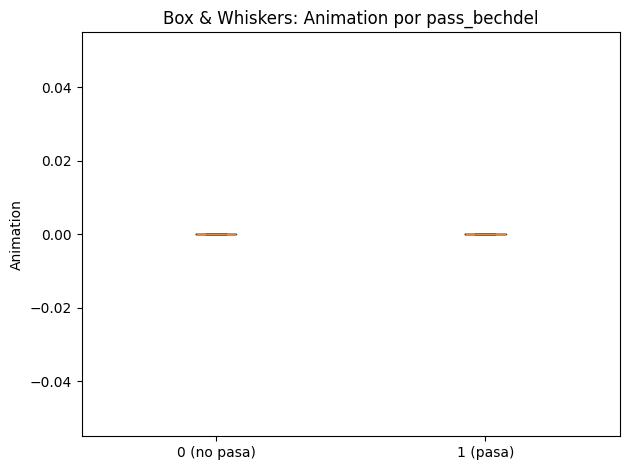

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


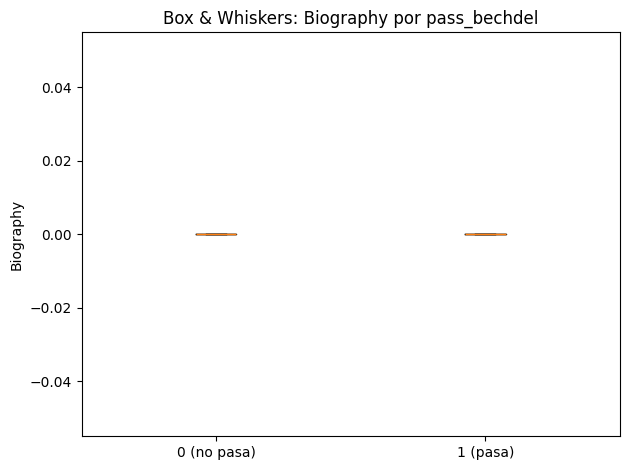

/tmp/ipykernel_25/277786986.py:116: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)


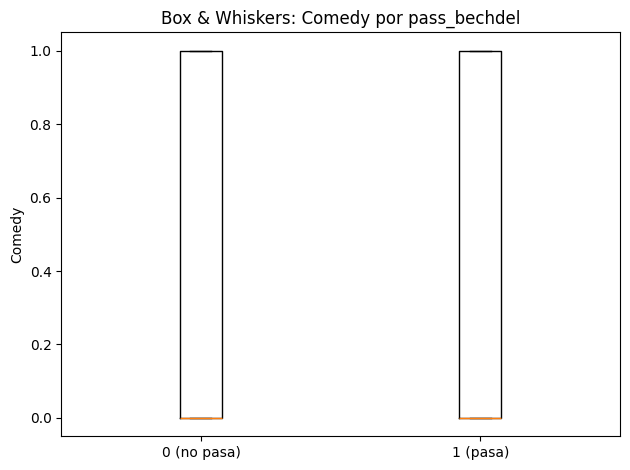

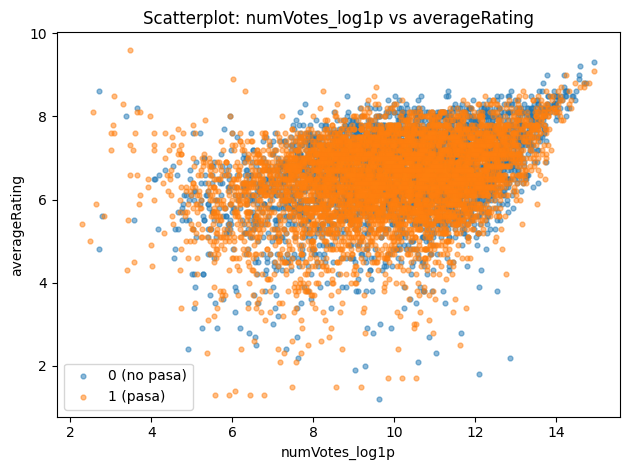

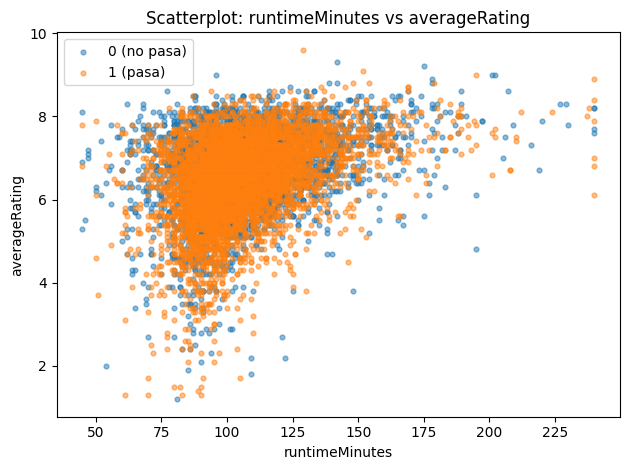

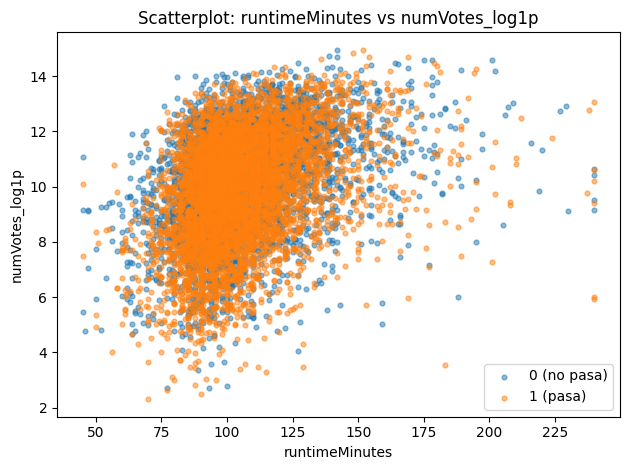

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math
import os
#Ponemos el merge en nuestro df
df = final.copy()              
#Variable objetivo 
target_col = "pass_bechdel"   
#Límite de plots por tipo para no saturar
max_plots = 12   

#Limpiamos y aseguramos tipos de datos
if target_col in df.columns:
    df[target_col] = pd.to_numeric(df[target_col], errors="coerce").fillna(0).astype(int)

# Si existen numVotes, crear versión log
if "numVotes" in df.columns:
    df["numVotes_log1p"] = np.log1p(pd.to_numeric(df["numVotes"], errors="coerce"))
#Imprimimos resumen general del dataset
print("=== RESUMEN GENERAL ===")
print(f"Shape: {df.shape[0]} filas x {df.shape[1]} columnas")
print("\nDtypes:")
print(df.dtypes)

dup_count = df.duplicated().sum()
print(f"\nDuplicados (filas): {dup_count}")

print("\nNulos por columna (top 20):")
print(df.isna().sum().sort_values(ascending=False).head(20))

#Generamos descripciones con numeros y categorias
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=["object", "string", "category", "bool"]).columns.tolist()

print("\n=== DESCRIPTIVOS NUMÉRICOS ===")
if numeric_cols:
    desc_num = df[numeric_cols].describe().T
    desc_num["missing"] = len(df) - desc_num["count"]
    desc_num["pct_missing"] = desc_num["missing"] / len(df)
    print(desc_num)
else:
    print("(No se detectaron columnas numéricas.)")

print("\n=== DESCRIPTIVOS CATEGÓRICOS ===")
def describe_cats(d):
    rows = []
    for c in d:
        s = df[c].astype("string")
        rows.append({
            "col": c,
            "n_unique": s.nunique(dropna=True),
            "top": s.value_counts(dropna=True).index[:1].tolist()[0] if s.nunique(dropna=True) > 0 else None,
            "top_freq": s.value_counts(dropna=True).iloc[:1].tolist()[0] if s.nunique(dropna=True) > 0 else 0,
            "missing": s.isna().sum(),
            "pct_missing": s.isna().mean()
        })
    return pd.DataFrame(rows).sort_values(by="n_unique", ascending=False)

if cat_cols:
    desc_cat = describe_cats(cat_cols)
    print(desc_cat.head(30))
else:
    print("(No se detectaron columnas categóricas.)")

#Generamos matriz de correlación
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(method="pearson")
    print("\nCORRELACIÓN")

    #Definimos el Heatmap
    fig, ax = plt.subplots(figsize=(min(0.45*len(numeric_cols)+4, 20),
                                    min(0.45*len(numeric_cols)+4, 20)))
    cax = ax.imshow(corr, interpolation='nearest', aspect='auto')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(numeric_cols)))
    ax.set_yticks(np.arange(len(numeric_cols)))
    ax.set_xticklabels(numeric_cols, rotation=90)
    ax.set_yticklabels(numeric_cols)
    ax.set_title("Matriz de correlación (numéricas)")
    plt.tight_layout()
    plt.show()

    # Top correlaciones con el target (si es numérico)
    if target_col in numeric_cols:
        cor_target = corr[target_col].drop(labels=[target_col]).abs().sort_values(ascending=False)
        print("\nTop correlaciones absolutas con el target:")
        print(cor_target.head(20))
else:
    print("\n(No hay columnas suficientes para calcular correlaciones.)")

#Generamos Histogramas
if numeric_cols:
    cols_to_plot = numeric_cols[:max_plots]
    for col in cols_to_plot:
        if df[col].dropna().empty:
            continue
        plt.figure()
        df[col].dropna().plot(kind="hist", bins=30)
        plt.title(f"Histograma: {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.tight_layout()
        plt.show()

#Definimos Box & Whiskers
if target_col in df.columns and df[target_col].dropna().nunique() == 2:
    cols_to_box = [c for c in numeric_cols if c != target_col][:max_plots]
    for col in cols_to_box:
        data0 = df.loc[df[target_col] == 0, col].dropna()
        data1 = df.loc[df[target_col] == 1, col].dropna()
        if data0.empty and data1.empty:
            continue
        plt.figure()
        plt.boxplot([data0, data1], labels=["0 (no pasa)", "1 (pasa)"], showfliers=False)
        plt.title(f"Box & Whiskers: {col} por {target_col}")
        plt.ylabel(col)
        plt.tight_layout()
        plt.show()

#Hacemos pares de candidatos para ver como se ven las relaciones con estos pares
candidate_pairs = [
    ("numVotes_log1p", "averageRating"),
    ("runtimeMinutes", "averageRating"),
    ("runtimeMinutes", "numVotes_log1p"),
]

pairs = []
for x, y in candidate_pairs:
    if x in df.columns and y in df.columns:
        pairs.append((x, y))

# Si no existen las columnas candidatas que definimos arriba, generamos pares automáticos (primeras 3 numéricas distintas al target)
if not pairs and len([c for c in numeric_cols if c != target_col]) >= 2:
    base = [c for c in numeric_cols if c != target_col][:4]
    pairs = list(combinations(base, 2))[:max_plots]

for x, y in pairs[:max_plots]:
    plt.figure()
    if target_col in df.columns and df[target_col].dropna().nunique() == 2:
        # Graficar dos capas por clase
        m0 = df[target_col] == 0
        m1 = df[target_col] == 1
        plt.scatter(df.loc[m0, x], df.loc[m0, y], alpha=0.5, label="0 (no pasa)", s=12)
        plt.scatter(df.loc[m1, x], df.loc[m1, y], alpha=0.5, label="1 (pasa)", s=12)
        plt.legend()
    else:
        plt.scatter(df[x], df[y], alpha=0.5, s=12)
    plt.xlabel(x); plt.ylabel(y)
    plt.title(f"Scatterplot: {x} vs {y}")
    plt.tight_layout()
    fname = f"scatter_{x}vs{y}.png".replace("/", "_")
    plt.show()

# Materalización en PostgreSQL

En esta sección después de realizar las pruebas unitarias, subimos los archivos tsv a nuestra base de datos para poder utilizar en nuestro notebook

In [6]:
#En este codigo vamos a subir los tsv a la base de datos PostgreSQL, de la misma formas que lo realizamos para la Tarea #3

import findspark
findspark.init('/usr/lib/python3.12/site-packages/pyspark')

from pyspark.sql import SparkSession
from pyspark.sql import functions as F, types as T

#Definimos tipos de datos para el esquema
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, DoubleType
)
#Definimos schema para datos de Imdb basics
BASICS_SCHEMA = StructType([
    StructField("tconst",         StringType(),  True),
    StructField("titleType",      StringType(),  True),
    StructField("primaryTitle",   StringType(),  True),
    StructField("originalTitle",  StringType(),  True),
    StructField("isAdult",        StringType(),  True),
    StructField("startYear",      StringType(),  True),
    StructField("endYear",        StringType(),  True),
    StructField("runtimeMinutes", StringType(),  True),
    StructField("genres",         StringType(),  True),
])
#Definimos schema para datos de Imdb ratings
RATINGS_SCHEMA = StructType([
    StructField("tconst",        StringType(), True),
    StructField("averageRating", StringType(), True),
    StructField("numVotes",      StringType(), True),
])

#Creamos la Spark Session
spark = (
    SparkSession.builder
        .appName("IMDb Materialization with Schemas")
        .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar")
        .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar")
        .getOrCreate()
)

# Definimos parametros
BASICS_TSV  = "title.basics.tsv"
RATINGS_TSV = "title.ratings.tsv"
PG_URL  = "jdbc:postgresql://host.docker.internal:5433/postgres"
PG_USER = "postgres"
PG_PASS = "testPassword"
TABLE_BASICS  = "imdb_basics_curated"
TABLE_RATINGS = "imdb_ratings_curated"
TABLE_JOINED  = "imdb_titles_joined"

#Cargamos el TSV con los esquemas
basics_raw = (
    spark.read.format("csv")
        .schema(BASICS_SCHEMA)
        .option("header", True)
        .option("sep", "\t")
        .option("nullValue", r"\N")
        .load(BASICS_TSV)
)

ratings_raw = (
    spark.read.format("csv")
        .schema(RATINGS_SCHEMA)
        .option("header", True)
        .option("sep", "\t")
        .option("nullValue", r"\N")
        .load(RATINGS_TSV)
)

#Control de outliers, ya que nuestro dataset tiene peliculas con duracion de menos de 30 minutos o mas de 240 minutos, los estandarizamos
#para tener valores mas equilibrados.
CLIP_LOW, CLIP_HIGH = 30.0, 240.0

#Ademas del control de outliers, tambien hacemos control de nulos, tipos de datos y duplicados.
basics_cur = (basics_raw
    .select("tconst", "titleType", "isAdult", "runtimeMinutes", "genres")
    .withColumn("isAdult", F.col("isAdult").cast(T.IntegerType()))
    .withColumn("isAdult", F.coalesce(F.col("isAdult"), F.lit(0)))
    .withColumn("runtimeMinutes", F.col("runtimeMinutes").cast(T.DoubleType()))
    .withColumn(
        "runtimeMinutes",
        F.when(F.col("runtimeMinutes").isNull(), F.lit(None).cast(T.DoubleType()))
         .otherwise(
            F.when(F.col("runtimeMinutes") < CLIP_LOW,  F.lit(CLIP_LOW))
             .when(F.col("runtimeMinutes") > CLIP_HIGH, F.lit(CLIP_HIGH))
             .otherwise(F.col("runtimeMinutes"))
         )
    )
    .withColumn(
        "genres",
        F.when(F.col("genres").isNull() | (F.col("genres") == ""), F.lit("Unknown"))
         .otherwise(F.col("genres"))
    )
    .filter((F.col("titleType") == "movie") & (F.col("isAdult") == 0))
    .dropDuplicates(["tconst"])
)
#De la misma forma que con el dataset de arriba, realizamos limpieza de los datos
ratings_cur = (ratings_raw
    .select("tconst", "averageRating", "numVotes")
    .withColumn("averageRating", F.col("averageRating").cast(T.DoubleType()))
    .withColumn("numVotes",      F.col("numVotes").cast(T.IntegerType()))
    .dropna(subset=["tconst"])
    .dropDuplicates(["tconst"])
)

#Ya que tenemos los datos limpios realizamos un LEFT JOIN de nuestro dataset de basics y de ratings
joined = (basics_cur.alias("b")
    .join(ratings_cur.alias("r"), on="tconst", how="left")
    .select(
        "tconst",
        F.col("b.titleType").alias("title_type"),
        F.col("b.isAdult").alias("is_adult"),
        F.col("b.runtimeMinutes").alias("runtime_minutes"),
        F.col("b.genres").alias("genres"),
        F.col("r.averageRating").alias("average_rating"),
        F.col("r.numVotes").alias("num_votes"),
    )
)

#Escribimos la data ya limpia a nuestra base de datos con "overwrite"
(
    basics_cur
        .select("tconst","titleType","isAdult","runtimeMinutes","genres")
        .write.format("jdbc")
        .mode("overwrite")
        .option("url", PG_URL)
        .option("user", PG_USER)
        .option("password", PG_PASS)
        .option("dbtable", TABLE_BASICS)  
        .save()
)

(
    ratings_cur
        .select("tconst","averageRating","numVotes")
        .write.format("jdbc")
        .mode("overwrite")
        .option("url", PG_URL)
        .option("user", PG_USER)
        .option("password", PG_PASS)
        .option("dbtable", TABLE_RATINGS) 
        .save()
)

(
    joined
        .write.format("jdbc")
        .mode("overwrite")
        .option("url", PG_URL)
        .option("user", PG_USER)
        .option("password", PG_PASS)
        .option("dbtable", TABLE_JOINED)   
        .save()
)

#Ya que guardamos la data en nuestra base de datos en PostgreSQL, podemos leerla y guardarla en la variable "df"
df = (
    spark.read.format("jdbc")
        .option("url", PG_URL)
        .option("user", PG_USER)
        .option("password", PG_PASS)
        .option("dbtable", TABLE_JOINED)
        .load()
)

df.printSchema()
df.show(10, truncate=False)


Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/16 16:31:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
                                                                                

root
 |-- tconst: string (nullable = true)
 |-- title_type: string (nullable = true)
 |-- is_adult: integer (nullable = true)
 |-- runtime_minutes: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- num_votes: integer (nullable = true)

+---------+----------+--------+---------------+---------------+--------------+---------+
|tconst   |title_type|is_adult|runtime_minutes|genres         |average_rating|num_votes|
+---------+----------+--------+---------------+---------------+--------------+---------+
|tt0001080|movie     |0       |NULL           |Unknown        |NULL          |NULL     |
|tt0001113|movie     |0       |NULL           |Unknown        |4.5           |21       |
|tt0001142|movie     |0       |NULL           |Unknown        |NULL          |NULL     |
|tt0001240|movie     |0       |NULL           |Drama          |3.8           |24       |
|tt0001614|movie     |0       |35.0           |Drama          |6.5           

In [ ]:
df.describe()

In [7]:
#Como inicialmente hicimos esto en un dataframe de Pandas para realizar el EDA en el entregable #1, lo transformamos a Spark DataFrame
from pyspark.sql import functions as F

bechdel_spark = spark.createDataFrame(bechdel)

In [8]:
#Unimos TODA nuestra data = Basics IMDB + Ratings IMDB + Bechdel Test
df_joined_full = (
    df.join(bechdel_spark, on="tconst", how="left")
)

In [9]:
df_joined_full.printSchema()
df_joined_full.show(100)

root
 |-- tconst: string (nullable = true)
 |-- title_type: string (nullable = true)
 |-- is_adult: integer (nullable = true)
 |-- runtime_minutes: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- num_votes: integer (nullable = true)
 |-- id: long (nullable = true)
 |-- imdbid: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- pass_bechdel: long (nullable = true)



[Stage 13:>                                                       (0 + 12) / 12]

+---------+----------+--------+---------------+--------------------+--------------+---------+----+------+-----+----+------+------------+
|   tconst|title_type|is_adult|runtime_minutes|              genres|average_rating|num_votes|  id|imdbid|title|year|rating|pass_bechdel|
+---------+----------+--------+---------------+--------------------+--------------+---------+----+------+-----+----+------+------------+
|tt0001080|     movie|       0|           NULL|             Unknown|          NULL|     NULL|NULL|  NULL| NULL|NULL|  NULL|        NULL|
|tt0001113|     movie|       0|           NULL|             Unknown|           4.5|       21|NULL|  NULL| NULL|NULL|  NULL|        NULL|
|tt0001142|     movie|       0|           NULL|             Unknown|          NULL|     NULL|NULL|  NULL| NULL|NULL|  NULL|        NULL|
|tt0001240|     movie|       0|           NULL|               Drama|           3.8|       24|NULL|  NULL| NULL|NULL|  NULL|        NULL|
|tt0001614|     movie|       0|          

In [ ]:
df_joined_full.filter(F.col("pass_bechdel").isNotNull()).count()


In [ ]:
df_joined_full.count()


In [ ]:
df_joined_full \
    .filter(F.col("pass_bechdel").isNotNull()) \
    .show(20, truncate=False)


In [10]:
from pyspark.sql import functions as F

#Filtramos por todo lo que NO es nulo, ya que la data nula no nos sirve para entrenar nuestro modelo (Bechdel nulo).
df_labeled = df_joined_full.filter(F.col("pass_bechdel").isNotNull())
print(df_labeled.count())
df_labeled.groupBy("pass_bechdel").count().show()
cols_ml = [
    "tconst",
    "runtime_minutes",
    "genres",
    "average_rating",
    "num_votes",
    "pass_bechdel"  # label
]
#Corremos y guardamos nuestros filtros definidos
df_ml = df_labeled.select(*cols_ml)
df_ml.show(5, truncate=False)
df_ml.printSchema()
df_ml = df_ml.filter(
    F.col("runtime_minutes").isNotNull() &
    F.col("average_rating").isNotNull() &
    F.col("num_votes").isNotNull()
)

9736


+------------+-----+
|pass_bechdel|count|
+------------+-----+
|           0| 4148|
|           1| 5588|
+------------+-----+



[Stage 36:>                                                         (0 + 1) / 1]

+---------+---------------+--------------------+--------------+---------+------------+
|tconst   |runtime_minutes|genres              |average_rating|num_votes|pass_bechdel|
+---------+---------------+--------------------+--------------+---------+------------+
|tt0021156|92.0           |Drama,Romance       |7.0           |8157     |0           |
|tt0032553|125.0          |Comedy,Drama,War    |8.4           |252875   |1           |
|tt0032599|92.0           |Comedy,Drama,Romance|7.8           |66752    |1           |
|tt0036323|97.0           |Action,Drama,War    |7.5           |10659    |0           |
|tt0039236|88.0           |Musical,Romance     |5.8           |293      |0           |
+---------+---------------+--------------------+--------------+---------+------------+
only showing top 5 rows
root
 |-- tconst: string (nullable = true)
 |-- runtime_minutes: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- num_votes: int

In [ ]:
df_ml.show(10)

In [11]:
from pyspark.sql import functions as F

#Definimos nuestra variable para realizar el entrenamiento/evaluacion
df_ml = df_ml.withColumn("label", F.col("pass_bechdel").cast("double"))

#Generamos una lista de géneros principales a codificar (Esto es con el proposito de mas adelante realizar One-Hot Encoding)
genre_list = [
    "Drama", "Comedy", "Action", "Romance", "Thriller", "Horror",
    "Documentary", "Animation", "Crime", "Adventure", "Sci-Fi",
    "Fantasy", "Family", "Mystery"
]

#Creamos una columna array de géneros separando por coma
df_genres = df_ml.withColumn(
    "genres_array",
    F.split(F.col("genres"), ",")
)

# Creamos columnas binarias genre_X (0/1)
for g in genre_list:
    col_name = f"genre_{g.replace('-', '_')}"
    df_genres = df_genres.withColumn(
        col_name,
        F.when(F.array_contains(F.col("genres_array"), g), F.lit(1.0)).otherwise(F.lit(0.0))
    )

print("Esquema después de agregar géneros codificados:")
df_genres.printSchema()

print("Ejemplo de filas:")
df_genres.select(
    "tconst", "genres", "runtime_minutes", "average_rating", "num_votes",
    "genre_Drama", "genre_Comedy", "genre_Action", "label"
).show(10, truncate=False)


Esquema después de agregar géneros codificados:
root
 |-- tconst: string (nullable = true)
 |-- runtime_minutes: double (nullable = true)
 |-- genres: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- num_votes: integer (nullable = true)
 |-- pass_bechdel: long (nullable = true)
 |-- label: double (nullable = true)
 |-- genres_array: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- genre_Drama: double (nullable = false)
 |-- genre_Comedy: double (nullable = false)
 |-- genre_Action: double (nullable = false)
 |-- genre_Romance: double (nullable = false)
 |-- genre_Thriller: double (nullable = false)
 |-- genre_Horror: double (nullable = false)
 |-- genre_Documentary: double (nullable = false)
 |-- genre_Animation: double (nullable = false)
 |-- genre_Crime: double (nullable = false)
 |-- genre_Adventure: double (nullable = false)
 |-- genre_Sci_Fi: double (nullable = false)
 |-- genre_Fantasy: double (nullable = false)
 |-- genre_F

+---------+-------------------------+---------------+--------------+---------+-----------+------------+------------+-----+
|tconst   |genres                   |runtime_minutes|average_rating|num_votes|genre_Drama|genre_Comedy|genre_Action|label|
+---------+-------------------------+---------------+--------------+---------+-----------+------------+------------+-----+
|tt0021156|Drama,Romance            |92.0           |7.0           |8157     |1.0        |0.0         |0.0         |0.0  |
|tt0032553|Comedy,Drama,War         |125.0          |8.4           |252875   |1.0        |1.0         |0.0         |1.0  |
|tt0032599|Comedy,Drama,Romance     |92.0           |7.8           |66752    |1.0        |1.0         |0.0         |1.0  |
|tt0036323|Action,Drama,War         |97.0           |7.5           |10659    |1.0        |0.0         |1.0         |0.0  |
|tt0039236|Musical,Romance          |88.0           |5.8           |293      |0.0        |0.0         |0.0         |0.0  |
|tt0039431|Comed

In [12]:
from pyspark.ml.feature import VectorAssembler

#Definimos columnas numéricas base
numeric_features = ["runtime_minutes", "average_rating", "num_votes"]

#Definimos columnas de géneros que acabamos de crear
genre_features = [f"genre_{g.replace('-', '_')}" for g in genre_list]

feature_cols = numeric_features + genre_features
print("Features usadas:", feature_cols)

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

data = assembler.transform(df_genres).select("features", "label")

# Hacemos split de entrenamiento y validación
train_df, val_df = data.randomSplit([0.8, 0.2], seed=42)

print("Train count:", train_df.count())
print("Validation count:", val_df.count())

print("Ejemplo de vector de features:")
train_df.show(5, truncate=False)


Features usadas: ['runtime_minutes', 'average_rating', 'num_votes', 'genre_Drama', 'genre_Comedy', 'genre_Action', 'genre_Romance', 'genre_Thriller', 'genre_Horror', 'genre_Documentary', 'genre_Animation', 'genre_Crime', 'genre_Adventure', 'genre_Sci_Fi', 'genre_Fantasy', 'genre_Family', 'genre_Mystery']


25/11/16 16:33:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

Train count: 7834


Validation count: 1884
Ejemplo de vector de features:


+------------------------------------+-----+
|features                            |label|
+------------------------------------+-----+
|(17,[0,1,2],[68.0,6.2,158.0])       |0.0  |
|(17,[0,1,2],[104.0,7.1,6211.0])     |0.0  |
|(17,[0,1,2,3],[75.0,4.2,156.0,1.0]) |0.0  |
|(17,[0,1,2,3],[78.0,7.0,2801.0,1.0])|1.0  |
|(17,[0,1,2,3],[79.0,6.6,713.0,1.0]) |1.0  |
+------------------------------------+-----+
only showing top 5 rows


# Entrenamiento de modelos

En esta sección, ya con nuestro dataset limpio y estandarizado, podemos proceder a entrenar nuestros modelos. (En una version inicial, se normalizaron los datos, pero basado en los resultados opté por limpiar el notebook y utilizar los no normalizados ya que para nuestro modelo mas eficiente (Random Forest) se obtuvo mejores resultados, consume menos memoría y tiene mejor rendimiento.

In [13]:
from pyspark.ml.classification import LogisticRegression

#Modelo 1: Logistic Regression con hiperparámetros razonables
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    regParam=0.1,         
    elasticNetParam=0.5   # mezclamos L1/L2
)

print("Entrenando Logistic Regression...")
model_lr = lr.fit(train_df)
print("Listo: Logistic Regression entrenado.")


Entrenando Logistic Regression...


25/11/16 16:33:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
[Stage 116:>                (0 + 1) / 1][Stage 117:=============> (11 + 1) / 12]

Listo: Logistic Regression entrenado.


In [14]:
from pyspark.ml.classification import GBTClassifier

# Modelo 2: GBTClassifier con hiperparámetros fijos
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=3,
    maxIter=20,
    seed=42
)

print("Entrenando GBTClassifier...")
model_gbt = gbt.fit(train_df)
print("Listo: GBTClassifier entrenado.")


Entrenando GBTClassifier...


Listo: GBTClassifier entrenado.


In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Predicciones en validation
pred_lr = model_lr.transform(val_df)
pred_gbt = model_gbt.transform(val_df)

#Evaluadores
binary_eval = BinaryClassificationEvaluator(labelCol="label")  # para AUC

multi_eval_acc  = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
multi_eval_prec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
multi_eval_rec  = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

#Logistic Regression
auc_lr  = binary_eval.evaluate(pred_lr, {binary_eval.metricName: "areaUnderROC"})
acc_lr  = multi_eval_acc.evaluate(pred_lr)
prec_lr = multi_eval_prec.evaluate(pred_lr)
rec_lr  = multi_eval_rec.evaluate(pred_lr)

#GBTClassifier
auc_gbt  = binary_eval.evaluate(pred_gbt, {binary_eval.metricName: "areaUnderROC"})
acc_gbt  = multi_eval_acc.evaluate(pred_gbt)
prec_gbt = multi_eval_prec.evaluate(pred_gbt)
rec_gbt  = multi_eval_rec.evaluate(pred_gbt)

print("Resultados de Logistic Regression:")
print(f"AUC:       {auc_lr:.4f}")
print(f"Accuracy:  {acc_lr:.4f}")
print(f"Precision: {prec_lr:.4f}")
print(f"Recall:    {rec_lr:.4f}")

print("\nResultados de GBTClassifier:")
print(f"AUC:       {auc_gbt:.4f}")
print(f"Accuracy:  {acc_gbt:.4f}")
print(f"Precision: {prec_gbt:.4f}")
print(f"Recall:    {rec_gbt:.4f}")


[Stage 393:>                                                        (0 + 9) / 9]

Resultados de Logistic Regression:
AUC:       0.5893
Accuracy:  0.5849
Precision: 0.3421
Recall:    0.5849

Resultados de GBTClassifier:
AUC:       0.6458
Accuracy:  0.6338
Precision: 0.6252
Recall:    0.6338


Vamos a proceder a realizar ajustes adicionales en el dataset para tratar de obtener mejores resultados.

In [16]:
from pyspark.sql import functions as F

#Empezamos de nuestra base del dataframe ya hecho
df_base = df_ml.withColumn("label", F.col("pass_bechdel").cast("double"))

#Dividimos nuestra columna de generos en columnas individuales
genres_separated = (
    df_base
    .select(F.explode(F.split(F.col("genres"), ",")).alias("genre_raw"))
    .withColumn("genre", F.trim(F.col("genre_raw")))
    .filter(F.col("genre").isNotNull() & (F.col("genre") != ""))
)

#Contamos géneros
genre_counts = genres_separated.groupBy("genre").count().orderBy(F.desc("count"))

print("Géneros detectados y su frecuencia:")
genre_counts.show(50, truncate=False) 

#Tomamos todos los géneros
genre_list = [row["genre"] for row in genre_counts.collect()]

print("Lista final de géneros que se van a codificar:")
print(genre_list)


Géneros detectados y su frecuencia:


+-----------+-----+
|genre      |count|
+-----------+-----+
|Drama      |5647 |
|Comedy     |3630 |
|Action     |1857 |
|Romance    |1770 |
|Adventure  |1708 |
|Crime      |1477 |
|Thriller   |1308 |
|Horror     |1178 |
|Mystery    |913  |
|Fantasy    |729  |
|Sci-Fi     |697  |
|Animation  |594  |
|Biography  |558  |
|Family     |509  |
|History    |319  |
|Music      |309  |
|Musical    |231  |
|War        |197  |
|Sport      |145  |
|Western    |113  |
|Documentary|109  |
|Film-Noir  |79   |
|Unknown    |4    |
|News       |4    |
+-----------+-----+



Lista final de géneros que se van a codificar:
['Drama', 'Comedy', 'Action', 'Romance', 'Adventure', 'Crime', 'Thriller', 'Horror', 'Mystery', 'Fantasy', 'Sci-Fi', 'Animation', 'Biography', 'Family', 'History', 'Music', 'Musical', 'War', 'Sport', 'Western', 'Documentary', 'Film-Noir', 'Unknown', 'News']


In [19]:
from pyspark.ml.feature import VectorAssembler

# Partimos de df_base 
df_genres = df_base.withColumn( "genres_array", F.split(F.col("genres"), ",") ) 

# Crear columnas dummies genre_X 
for g in genre_list: 
    col_name = f"genre_{g.replace('-', '_')}" 
    df_genres = df_genres.withColumn( col_name, F.when(F.array_contains(F.col("genres_array"), g), F.lit(1.0)).otherwise(F.lit(0.0)) )
#Creamos nuevas variables numericas para mejorar resultados de la validacion

#Log de numVotes para suavizar la distribución
df_genres = df_genres.withColumn(
    "log_numVotes",
    F.log1p(F.col("num_votes").cast("double"))
)

#Realizamos varios buckets de rating: 0=bajo, 1=medio, 2=alto
df_genres = df_genres.withColumn(
    "rating_bucket",
    F.when(F.col("average_rating") < 5, F.lit(0.0))
     .when(F.col("average_rating") < 7, F.lit(1.0))
     .otherwise(F.lit(2.0))
)

#Realizamos varios buckets de duración: 0=corta (<60), 1=media (60-120), 2=larga (>120)
df_genres = df_genres.withColumn(
    "runtime_bucket",
    F.when(F.col("runtime_minutes") < 60, F.lit(0.0))
     .when(F.col("runtime_minutes") <= 120, F.lit(1.0))
     .otherwise(F.lit(2.0))
)

#Volvemos a definir las columnas de features con la data ya limpia e splitteamos de la misma forma que lo realizamos arriba.

numeric_features = [
    "runtime_minutes",
    "average_rating",
    "num_votes",
    "log_numVotes",
    "rating_bucket",
    "runtime_bucket"
]

genre_features = [f"genre_{g.replace('-', '_')}" for g in genre_list]

feature_cols = numeric_features + genre_features

print("Total de features:", len(feature_cols))
print("Algunas features:", feature_cols[:15])

assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features"
)

data = assembler.transform(df_genres).select("features", "label")

# Split de entrenamiento/validacion
train_df, val_df = data.randomSplit([0.8, 0.2], seed=42)

print("Train count:", train_df.count())
print("Validation count:", val_df.count())

print("Ejemplo de vector de features:")
train_df.show(5, truncate=False)


Total de features: 30
Algunas features: ['runtime_minutes', 'average_rating', 'num_votes', 'log_numVotes', 'rating_bucket', 'runtime_bucket', 'genre_Drama', 'genre_Comedy', 'genre_Action', 'genre_Romance', 'genre_Adventure', 'genre_Crime', 'genre_Thriller', 'genre_Horror', 'genre_Mystery']


Train count: 7834


Validation count: 1884
Ejemplo de vector de features:


[Stage 438:>                                                        (0 + 1) / 1]

+----------------------------------------------------------------------+-----+
|features                                                              |label|
+----------------------------------------------------------------------+-----+
|(30,[0,1,2,3,4,5,6],[66.0,7.2,741.0,6.60934924316738,2.0,1.0,1.0])    |1.0  |
|(30,[0,1,2,3,4,5,6],[78.0,7.0,2801.0,7.938088726896952,2.0,1.0,1.0])  |1.0  |
|(30,[0,1,2,3,4,5,6],[82.0,6.1,242.0,5.493061443340548,1.0,1.0,1.0])   |1.0  |
|(30,[0,1,2,3,4,5,6],[82.0,7.4,23104.0,10.047804323304367,2.0,1.0,1.0])|1.0  |
|(30,[0,1,2,3,4,5,6],[82.0,8.1,40.0,3.713572066704308,2.0,1.0,1.0])    |1.0  |
+----------------------------------------------------------------------+-----+
only showing top 5 rows


In [20]:
from pyspark.ml.classification import LogisticRegression
#Entrenamos de nuevo nuestros modelos con la data nueva
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    regParam=0.05,       
    elasticNetParam=0.5  
)

print("Entrenando Logistic Regression (mejorada)...")
model_lr = lr.fit(train_df)
print("Listo: Logistic Regression entrenado.")


Entrenando Logistic Regression (mejorada)...


[Stage 525:>                (0 + 1) / 1][Stage 526:>              (0 + 12) / 12]

Listo: Logistic Regression entrenado.


In [21]:
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier

# Modelo 2: GBTClassifier
gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=5,
    maxIter=40,
    seed=42
)

print("Entrenando GBTClassifier (mejorado)...")
model_gbt = gbt.fit(train_df)
print("Listo: GBTClassifier entrenado.")

# Modelo 3: RandomForest Nota: Este lo agregamos para visualizar otro modelo y su rendimiento.
rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    numTrees=80,
    maxDepth=7,
    seed=42
)

print("Entrenando RandomForestClassifier...")
model_rf = rf.fit(train_df)
print("Listo: RandomForest entrenado.")


Entrenando GBTClassifier (mejorado)...


Listo: GBTClassifier entrenado.
Entrenando RandomForestClassifier...


25/11/16 16:40:23 WARN DAGScheduler: Broadcasting large task binary with size 1162.3 KiB
                                                                                

Listo: RandomForest entrenado.


In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Predicciones
pred_lr  = model_lr.transform(val_df)
pred_gbt = model_gbt.transform(val_df)
pred_rf  = model_rf.transform(val_df)

binary_eval = BinaryClassificationEvaluator(labelCol="label")  # para AUC
multi_eval_acc  = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
multi_eval_prec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
multi_eval_rec  = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

def evaluar_modelo(pred_df, nombre):
    auc  = binary_eval.evaluate(pred_df, {binary_eval.metricName: "areaUnderROC"})
    acc  = multi_eval_acc.evaluate(pred_df)
    prec = multi_eval_prec.evaluate(pred_df)
    rec  = multi_eval_rec.evaluate(pred_df)
    print(f"\nResultados de {nombre}:")
    print(f"AUC:       {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")

evaluar_modelo(pred_lr,  "Logistic Regression")
evaluar_modelo(pred_gbt, "GBTClassifier")
evaluar_modelo(pred_rf,  "RandomForestClassifier")



Resultados de Logistic Regression:
AUC:       0.6371
Accuracy:  0.5939
Precision: 0.6227
Recall:    0.5939



Resultados de GBTClassifier:
AUC:       0.6554
Accuracy:  0.6327
Precision: 0.6308
Recall:    0.6327


[Stage 1315:>                                                       (0 + 9) / 9]


Resultados de RandomForestClassifier:
AUC:       0.6649
Accuracy:  0.6279
Precision: 0.6368
Recall:    0.6279


En esta sección (aunque no fuera necesario), entrenamos otros modelos que encontré en las librerias de Spark para visualizar si nos pueden dar mejores resultados.

In [ ]:
from pyspark.ml.classification import LinearSVC, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

#Modelos adicionales a correr:
#Linear SVM (LinearSVC), Naive Bayes y Decision Tree

#Linear SVM
svm = LinearSVC(
    featuresCol="features",
    labelCol="label",
    maxIter=50,
    regParam=0.1
)

print("Entrenando Linear SVM...")
model_svm = svm.fit(train_df)
print("Listo: SVM entrenado.")

pred_svm = model_svm.transform(val_df)


# Naive Bayes
nb = NaiveBayes(
    featuresCol="features",
    labelCol="label",
    modelType="multinomial",
    smoothing=1.0
)

print("\nEntrenando Naive Bayes...")
model_nb = nb.fit(train_df)
print("Listo: Naive Bayes entrenado.")

pred_nb = model_nb.transform(val_df)


#Decision Tree
dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="label",
    maxDepth=7
)

print("\nEntrenando Decision Tree...")
model_dt = dt.fit(train_df)
print("Listo: Decision Tree entrenado.")

pred_dt = model_dt.transform(val_df)




In [ ]:
#Evaluacion de nuevos modelos agregados

binary_eval = BinaryClassificationEvaluator(labelCol="label")
multi_eval_acc  = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy")
multi_eval_prec = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision")
multi_eval_rec  = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall")

def evaluar(pred, nombre):
    auc  = binary_eval.evaluate(pred, {binary_eval.metricName: "areaUnderROC"})
    acc  = multi_eval_acc.evaluate(pred)
    prec = multi_eval_prec.evaluate(pred)
    rec  = multi_eval_rec.evaluate(pred)
    print(f"\n---- {nombre} ----")
    print(f"AUC:       {auc:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")

evaluar(pred_svm, "Linear SVM (LinearSVC)")
evaluar(pred_nb,  "Naive Bayes (Multinomial)")
evaluar(pred_dt,  "Decision Tree")


# Análisis de resultados

Realizamos un gráfico de feature importance para nuestro mejor modelo que fue el Random Forest, además de las metricas que ya utilizamos.

Cantidad de features declaradas: 30
Cantidad de importancias en el modelo: 30
Top 30 features más importantes según RandomForest:
+-----------------+---------------------+
|feature          |importance           |
+-----------------+---------------------+
|genre_Action     |0.14592085020030096  |
|average_rating   |0.12173121467776848  |
|num_votes        |0.09137691660615253  |
|runtime_minutes  |0.08751633126772464  |
|genre_Crime      |0.0780893308465338   |
|log_numVotes     |0.07192933941581657  |
|genre_Western    |0.05142840416382764  |
|genre_Adventure  |0.048774773702215876 |
|rating_bucket    |0.04539525985917465  |
|genre_Romance    |0.039166371998405385 |
|genre_Horror     |0.03685753129315249  |
|genre_Sci_Fi     |0.027183216679529353 |
|genre_Drama      |0.021273657594039076 |
|genre_Animation  |0.014629533793959055 |
|genre_War        |0.014401262345660406 |
|genre_Comedy     |0.013916858939960416 |
|genre_Sport      |0.012833566075922426 |
|genre_Thriller   |0.012318680

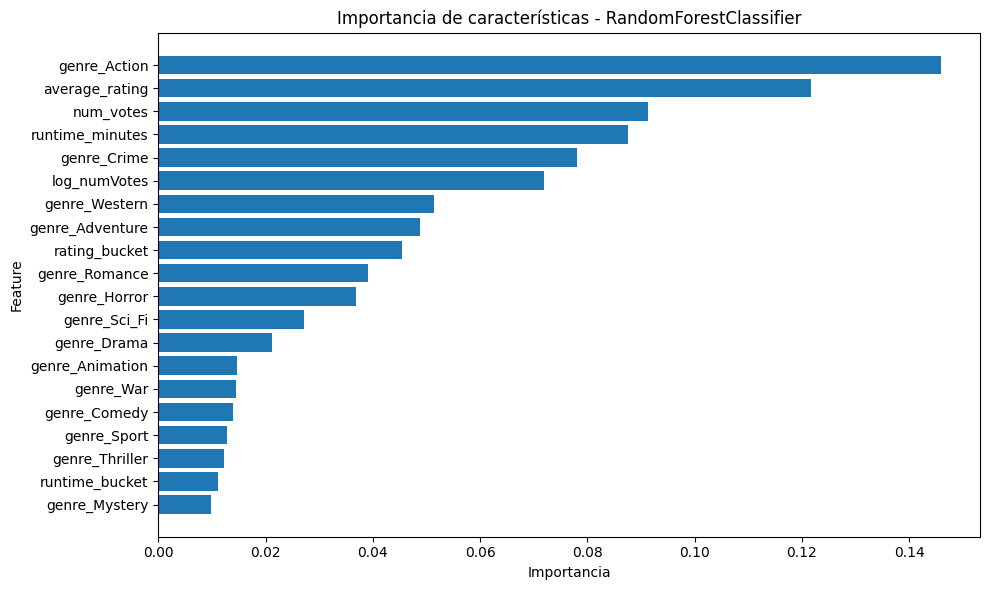

In [23]:
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

#Reconstruimos la lista de columnas de features igual que cuando armamos el VectorAssembler

numeric_features = [
    "runtime_minutes",
    "average_rating",
    "num_votes",
    "log_numVotes",
    "rating_bucket",
    "runtime_bucket"
]

genre_features = [f"genre_{g.replace('-', '_')}" for g in genre_list]

feature_cols = numeric_features + genre_features

print("Cantidad de features declaradas:", len(feature_cols))

#Extraer importancias desde el modelo de Random Forest
importances = model_rf.featureImportances
n_imp = importances.size
print("Cantidad de importancias en el modelo:", n_imp)

# En caso de que haya menos importancias que columnas,
# nos quedamos solo con las primeras n_imp columnas
if n_imp < len(feature_cols):
    print("Modelo tiene menos importancias que columnas declaradas; ajustado")
    feature_cols_used = feature_cols[:n_imp]
else:
    feature_cols_used = feature_cols

#Emparejar cada importancia con el nombre de su feature
imp_pairs = [
    (feature_cols_used[i], float(importances[i]))
    for i in range(n_imp)
]

#Pasarlo a DataFrame de Spark para poder verlo ordenado
df_importance = (
    spark.createDataFrame(imp_pairs, ["feature", "importance"])
         .orderBy(F.desc("importance"))
)

print("Top 30 features más importantes según RandomForest:")
df_importance.show(30, truncate=False)

#Convertir a pandas y graficar las TOP 20

topN = 20
pdf_imp = df_importance.limit(topN).toPandas()

# Ordenamos de menor a mayor para que el gráfico de barras horizontales se vea de abajo hacia arriba
pdf_imp = pdf_imp.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(pdf_imp["feature"], pdf_imp["importance"])
plt.xlabel("Importancia")
plt.ylabel("Feature")
plt.title("Importancia de características - RandomForestClassifier")
plt.tight_layout()
plt.show()


### Análisis de Resultados

En primer lugar se utilizó **Logistic Regression** como modelo lineal base. En una primera iteración, sin modificación de atributos, la regresión logística obtuvo métricas modestas (AUC ≈ 0.59, accuracy ≈ 0.58, con una precisión relativamente baja). Tras realizar un poco de  feature engineering (creación de separación de géneros, log_numVotes, buckets de rating y duración), el desempeño de este modelo mejoró de forma visible: la AUC se elevó aproximadamente a 0.637, la accuracy rondó el 0.59 y la precisión se situó alrededor de 0.62. Esto muestra que Logistic Regression se beneficia mucho de una buena representación de las variables, pero sigue siendo un modelo lineal: sólo capta relaciones aproximadamente lineales entre las características (por ejemplo, “a mayor rating promedio, mayor probabilidad de pasar el test”) y no es capaz de modelar interacciones complejas entre géneros, duración y popularidad. A pesar de ello, es un modelo útil como referencia y es muy interpretable, por lo que sirve como baseline razonable para comparar con modelos más sofisticados.

El segundo modelo utilizado fue **GBTClassifier** (Gradient-Boosted Trees). Este modelo de boosting de árboles puede capturar relaciones no lineales y efectos de interacción entre variables que Logistic Regression no ve. En el código utilizado (profundidad moderada y un número de iteraciones razonable para no saturar el entorno), GBT mostró métricas sistemáticamente superiores a la regresión logística: AUC ≈ 0.655, accuracy ≈ 0.63 y precisión y recall en torno a 0.63. Es decir, el modelo boosteado logra separar algo mejor las películas que pasan y no pasan el test de Bechdel, aprovechando combinaciones de géneros (por ejemplo, ciertos patrones en Horror, Documentary o Drama), junto con duración y popularidad. Sin embargo, el incremento respecto a Logistic Regression, aunque consistente, no es significante, lo que sugiere que la señal disponible en los metadatos es limitada y que, más allá de cierto punto, el modelo está cercano al techo de información que pueden aportar estas variables.

El tercer modelo principal fue **RandomForestClassifier**, que resultó ser el mejor de los probados. Con un número moderado de árboles y una profundidad media, el Random Forest alcanzó aproximadamente AUC = 0.665, accuracy ≈ 0.628, precisión ≈ 0.637 y recall ≈ 0.628, superando ligeramente a GBT tanto en AUC como en precisión. Además de sus buenas métricas, este modelo permitió analizar la importancia de las características, lo que aportó información adicional sobre qué variables están impulsando las predicciones: las más importantes fueron average_rating, runtime_bucket, num_votes y runtime_minutes, seguidas de varios géneros como genre_Horror, genre_Documentary, genre_Drama, genre_Action y genre_Animation. Esto sugiere que el random forest está usando una combinación de “tipo de historia” (género) y “perfil de recepción” (duración, calificación, popularidad) para aproximar la probabilidad de que una película pase el Test de Bechdel. El hecho de que géneros como Horror y Documentary aparezcan con mucha importancia indica que en esos grupos el patrón de representación femenina (y por tanto de cumplimiento del test) es más diferenciado. Adicionalmente, se consideró realizar normalización en los datos, pero ya que Random Forest fue nuestro modelo mas eficiente, este mismo no se ve beneficiado de datos normalizados ya que estos modelos usan splits en árboles basados en rangos relativos, no en magnitudes absolutas, por lo cuál se decidió excluir del análisis.

Además de estos tres modelos principales, se probaron otros clasificadores de Spark como **Linear SVM (LinearSVC)**, **Naive Bayes** y **DecisionTreeClassifier** para complementar el análisis. La SVM lineal obtuvo resultados muy similares a Logistic Regression (AUC ≈ 0.638, accuracy ≈ 0.62), confirmando que los modelos lineales tienen un rendimiento comparable cuando se les ofrecen las mismas features. El árbol de decisión individual alcanzó métricas intermedias (AUC ≈ 0.62, accuracy ≈ 0.63), por debajo del Random Forest y GBT, lo que es coherente con la idea de que un solo árbol es menos estable y menos expresivo que un ensamble de árboles. Naive Bayes, en cambio, mostró el peor desempeño (AUC ≈ 0.53), fundamentalmente porque sus supuestos de independencia fuerte entre features y su naturaleza pensada para conteos discretos no se ajustan bien a una mezcla de variables numéricas continuas y generos separados correlacionadas entre sí.

Al comparar los tres modelos principales **en conjunto**, se observamos un patrón: Logistic Regression actúa como baseline interpretable, GBT mejora el desempeño al capturar no linealidades, y Random Forest ofrece el mejor equilibrio entre capacidad predictiva y robustez. RandomForestClassifier sobresale ligeramente en AUC y precisión, probablemente porque, al promediar muchos árboles entrenados sobre subconjuntos del espacio de características y de los datos, logra modelar interacciones complejas sin sobreajustar tanto como un único árbol profundo, y con menos sensibilidad a pequeños cambios que GBT. GBT, por su parte, también aprende relaciones no lineales pero, con la configuración usada (limitada por recursos computacionales), no llegó a superar al bosque aleatorio en este caso concreto. Logistic Regression y Linear SVM, aunque quedaron por debajo en métrica, cumplen un papel importante como referencia lineal y ayudan a evidenciar el aporte marginal de los modelos basados en árboles.

Finalmente, es importante destacar que, aunque las métricas (AUC alrededor de 0.66 para el mejor modelo) puedan parecer moderadas en términos absolutos, son coherentes con la naturaleza del problema y las restricciones del dataset. El Test de Bechdel evalúa un aspecto muy específico del contenido narrativo (interacciones entre mujeres con nombre sobre temas no relacionados con hombres), mientras que las features disponibles son únicamente metadatos agregados (géneros, duración, rating promedio y votos). No se dispone de guiones, diálogos, sinopsis detalladas ni información directa sobre personajes femeninos, que serían las fuentes más naturales de señal. En este contexto, lograr una AUC cercana a 0.66–0.67 con metadatos únicamente es razonable y está alineado con lo que se reporta para tareas similares. En conjunto, el análisis muestra que: (1) la ingeniería de características mejora claramente el desempeño de los modelos, (2) los modelos basados en árboles (RandomForest y GBT) funcionan mejor que los lineales al explotar interacciones complejas, y (3) existe un límite práctico al rendimiento alcanzable con este tipo de datos.
